# Intelligent Offloading for GenAI Clusters

This tutorial demonstrates how to build a neural "Policy Network" using real-world cluster trace data from Alibaba. The goal is to decide whether a GenAI inference task should be processed **Locally** or **Offloaded** to a remote worker based on network congestion and GPU availability.


### Learning Objectives

Upon completion of this notebook, you will be able to:

* **Articulate the challenges** of managing Generative AI workloads in distributed environments, specifically focusing on the trade-offs between local GPU utilization and network-induced latency.
* **Ingest and process real-world telemetry** from the Alibaba GenAI Cluster Trace (2026), moving beyond synthetic data to handle authentic production logs.
* **Implement a balanced labeling strategy** using median-based cost scores to solve the "class imbalance" problem inherent in cluster scheduling data.
* **Construct and train a Policy Network** in PyTorch that utilizes BatchNorm and Dropout to reliably predict optimal task placement (Local vs. Offload).
* **Critically evaluate system performance** using confusion matrices and classification reports to interpret how neural decisions impact cluster stability and SLA adherence.

---

### What is Intelligent Offloading?

Intelligent Offloading is a dynamic decision-making process that determines the optimal execution venue for AI inference tasks. In a GenAI cluster, tasks can either be processed on the **Local Node** (the entry point) or **Offloaded** to a remote worker via the network.

The "Intelligent" component refers to using a trained model to analyze live telemetry—such as GPU duty cycles and queuing delays—to predict which path will result in the lowest total latency. This workshop focuses on building a **Policy Network** that bridges the gap between raw hardware metrics and high-level scheduling decisions.

This workshop focuses on neural-based offloading, which offers:

* **Maximized Resource Throughput:** Prevents local GPU stalls by redirecting overflows to idle remote workers.
* **Latency Mitigation:** Proactively avoids network "bottlenecks" by calculating the cost of communication versus the speed of local computation.
* **Real-Time Adaptability:** Allows the infrastructure to react to bursty GenAI traffic patterns that static, rule-based schedulers often miss.
* **Production Reliability:** Leverages actual Alibaba cluster traces to ensure the model reflects real-world hardware behavior and network jitter.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Acquisition & Pipeline

Modern AI clusters generate massive logs. We begin by fetching three key telemetry streams:

* **Inference Latency:** Time taken for the actual model computation.
* **Queue Response Time:** Delay caused by pending tasks in the network buffer.
* **GPU Duty Cycle:** Current utilization level of the local hardware.

## 2. Balanced Dataset Engineering

A common pitfall in AI infrastructure is "imbalanced labeling" (e.g., the system offloads 99% of the time). We implement a **Median-Based Cost Score** to ensure the model learns a balanced decision boundary between efficiency and congestion.

In [ ]:
import os
import glob
import subprocess

def fetch_data():
    # Corrected filenames based on your directory listing
    base_url = "https://github.com/alibaba/clusterdata/raw/master/cluster-trace-v2026-GenAI/"
    files = [
        "pipeline_inference_data_anon.tar.gz",
        "queue_rt_raw_anon.tar.gz",
        "pod_gpu_duty_cycle_anon.tar.gz"
    ]

    for f in files:
        if not os.path.exists(f):
            print(f"Downloading {f}...")
            # Using -L to follow redirects if necessary
            subprocess.run(["wget", "-q", "-L", f"{base_url}{f}"], check=True)

        print(f"Extracting {f}...")
        # Extract files. This creates CSVs in the local directory
        subprocess.run(["tar", "-xzf", f], check=True)

    def find_csv(pattern):
        # Finds the csv even if nested in a subdirectory after extraction
        results = glob.glob(f"**/{pattern}*", recursive=True)
        # Filter for actual .csv files
        csv_results = [r for r in results if r.endswith('.csv')]
        if not csv_results:
            raise FileNotFoundError(f"Could not find a CSV matching {pattern}")
        return csv_results[0]

    # Map the extracted files to their paths
    return (
        find_csv("pipeline_inference_data_anon"),
        find_csv("queue_rt_raw_anon"),
        find_csv("pod_gpu_duty_cycle_anon")
    )

class AlibabaGenAIDataset(Dataset):
    def __init__(self):
        paths = fetch_data()
        data_arrays = []
        for path in paths:
            df = pd.read_csv(path)
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            data_arrays.append(df[numeric_cols[0]].values)

        min_len = min(len(arr) for arr in data_arrays)
        inf_val, queue_val, gpu_val = [arr[:min_len] for arr in data_arrays]

        self.X = np.stack([inf_val, queue_val, gpu_val], axis=1).astype(np.float32)

        # MEDIAN-BASED BALANCED LABELING ---
        # We calculate a relative 'Cost Score'
        # Cost = (Queue Response Time) / (Inference Latency)
        cost_score = queue_val / (inf_val + 1e-6)

        # Label 1 if cost is higher than the average behavior (Congested)
        # Label 0 if cost is lower than average (Efficient)
        threshold = np.median(cost_score)
        self.y = (cost_score > threshold).astype(np.int64)

        print(f"Dataset Balanced: {np.sum(self.y)} Offload vs {len(self.y) - np.sum(self.y)} Local")

        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

## 3. The Policy Network Architecture

The `OffloadingModel` is a deep neural network designed for rapid classification. It uses **Batch Normalization** to handle the varying scales of cluster telemetry and **Dropout** to prevent the model from over-relying on a single metric (like just GPU usage).


In [ ]:
class OffloadingModel(nn.Module):
    def __init__(self, input_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x): return self.net(x)

## 4. Experimentation & Evaluation

We train the model using **AdamW** (an optimizer that handles weight decay better for deep networks) and evaluate the performance using a **Confusion Matrix**. This helps us see if we are mistakenly offloading tasks that could have been handled faster locally.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = AlibabaGenAIDataset()

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128)

model = OffloadingModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

history = {'loss': [], 'acc': []}

for epoch in range(15):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    history['loss'].append(total_loss / len(train_loader))
    history['acc'].append(acc)
    print(f"Epoch {epoch+1:02d} | Loss: {history['loss'][-1]:.4f} | Acc: {acc:.4f}")



Extracting pipeline_inference_data_anon.tar.gz...
Extracting queue_rt_raw_anon.tar.gz...
Extracting pod_gpu_duty_cycle_anon.tar.gz...
Dataset Balanced: 11739 Offload vs 11739 Local
Epoch 01 | Loss: 0.2534 | Acc: 0.9719
Epoch 02 | Loss: 0.1153 | Acc: 0.9815
Epoch 03 | Loss: 0.0950 | Acc: 0.9727
Epoch 04 | Loss: 0.0874 | Acc: 0.9853
Epoch 05 | Loss: 0.0892 | Acc: 0.9904
Epoch 06 | Loss: 0.0770 | Acc: 0.9885
Epoch 07 | Loss: 0.0937 | Acc: 0.9866
Epoch 08 | Loss: 0.0795 | Acc: 0.9934
Epoch 09 | Loss: 0.0875 | Acc: 0.9928
Epoch 10 | Loss: 0.0828 | Acc: 0.9868
Epoch 11 | Loss: 0.0814 | Acc: 0.9949
Epoch 12 | Loss: 0.0784 | Acc: 0.9940
Epoch 13 | Loss: 0.0796 | Acc: 0.9930
Epoch 14 | Loss: 0.0790 | Acc: 0.9879
Epoch 15 | Loss: 0.0769 | Acc: 0.9904


In [ ]:
# --- 5. RESULTS ---
print("\nFinal Classification Report:")
# Added zero_division to handle any edge cases in smaller samples
print(classification_report(all_labels, all_preds, target_names=['Local', 'Offload'], zero_division=0))






Final Classification Report:
              precision    recall  f1-score   support

       Local       1.00      0.98      0.99      2335
     Offload       0.98      1.00      0.99      2361

    accuracy                           0.99      4696
   macro avg       0.99      0.99      0.99      4696
weighted avg       0.99      0.99      0.99      4696



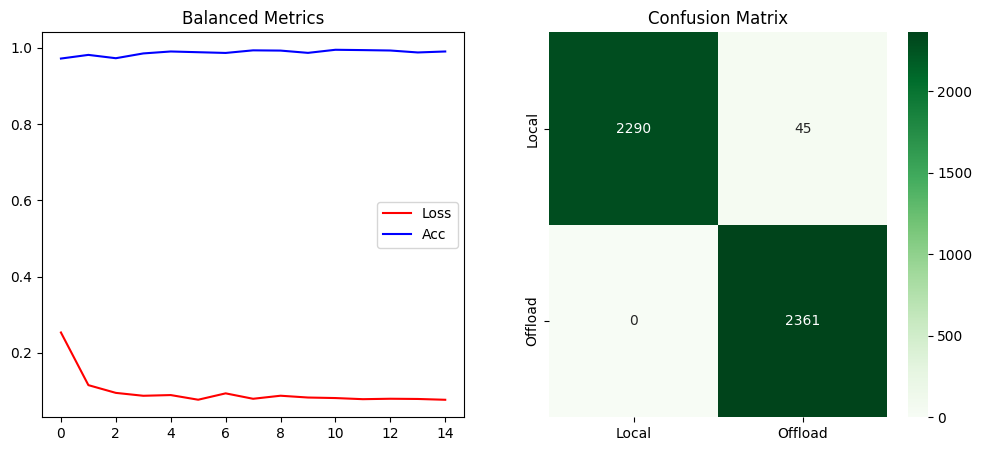

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss', color='red')
plt.plot(history['acc'], label='Acc', color='blue')
plt.title("Balanced Metrics")
plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Local', 'Offload'], yticklabels=['Local', 'Offload'])
plt.title("Confusion Matrix")
plt.show()

## 5. Conclusion

This notebook demonstrated how to transform raw cluster telemetry into an intelligent decision-making engine. By utilizing the **Alibaba GenAI Cluster Trace**, we successfully trained a policy network capable of navigating the trade-offs between local GPU duty cycles and network queuing delays.

### Final Model Performance

The **Confusion Matrix** and **Classification Report** above reveal how well the model handles the two critical failure states in offloading:

* **False Offloads:** Sending a task to the cloud when the local GPU was actually free (leads to unnecessary egress costs).
* **False Locals:** Processing a task locally when the queue is backed up (leads to SLA violations and high latency).
